In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm 
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from scipy.sparse.linalg import svds
from matplotlib.colors import LinearSegmentedColormap

First we load the data and epoch it.

In [2]:
raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=False)

Reading /Users/sashko/Documents/code/python/eeg_llm/sep_uwgr_prepro.fdt


/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_2073/2354897670.py:1: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: ['1']
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated


We extract the data and also the epoch average and store them in separate arrays.

In [3]:
data = epochs.get_data()
avg_data = epochs.average().data

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


We perform SVD on the (centered) average data. Note that centering doesn't change much in our case because, for each channel, the avaerage is basically zero, at least compared to the signal.

In [897]:
U, S, Vh = np.linalg.svd(avg_data - np.mean(avg_data, axis=0), full_matrices=True)

We check how the first right-eigenvector (corresponding to the time-series shape) looks like, compare it with a couple of channels for reference and also plot the singular values.

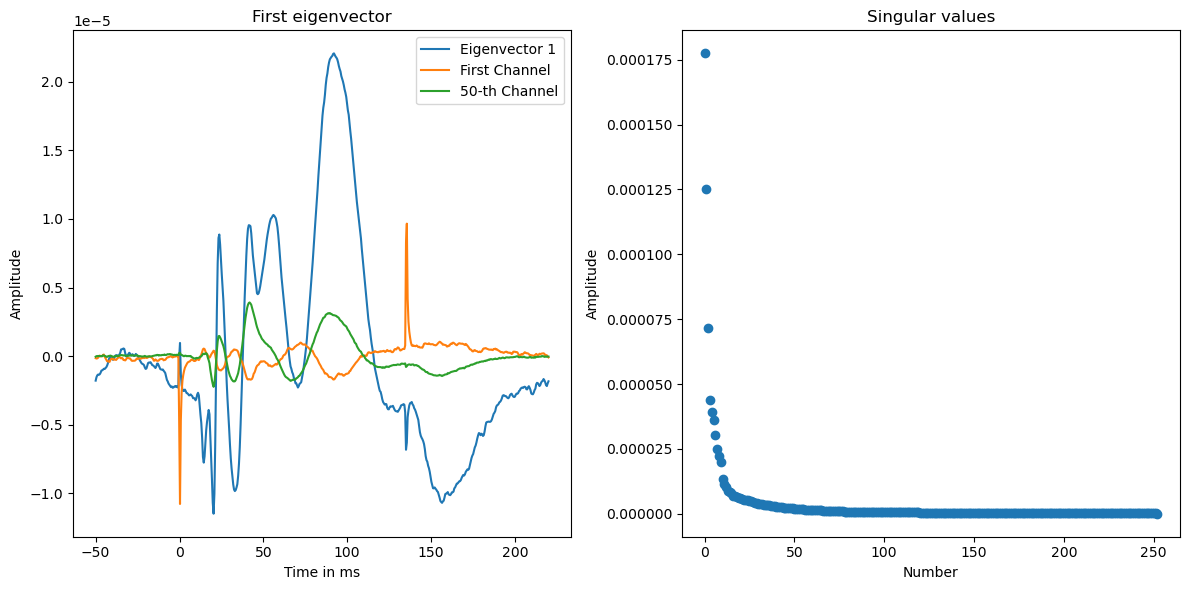

In [900]:
timepoints = np.linspace(tmin, tmax, 554)

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the first subplot
eig_n = 0

ax1.plot(timepoints * 1000, S[eig_n]*Vh[eig_n], label=f'Eigenvector {eig_n+1}')
ax1.plot(timepoints * 1000, avg_data[0], label=f'First Channel')
ax1.plot(timepoints * 1000, avg_data[49], label=f'50-th Channel')
ax1.set_title(f'First eigenvector')
ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot on the second subplot
ax2.plot(S.T,'o')
ax2.set_title('Singular values')
ax2.set_xlabel('Number')
ax2.set_ylabel('Amplitude')

# Display the plots
plt.tight_layout()
plt.show()

We see that the shape of the first eigenvector corresponds to the SEP. Indeed, both channel averages over trials follow this trend to a great extent.

Now let's think of every single timepoint of every trial as a vector in sensor-space. With the other (left) eigenvectors, we can reduce the dimensionality of sensor-space in order to visualize how all time-points disperse geometrically in two dimensions, corresponding to the first two principal components.

However, after projecting, we also normalize with the norm of each timepoint. This is to compare the proportion of the timepoint vectors in sensor space that are projected onto the eigenvectors. This amounts to taking the correlation between the spatial eigenvectors and the timepoint spatial vectors.

In [901]:
data_reshaped = data.transpose(1, 0, 2).reshape(data.shape[1], -1).T

In [902]:
datapoints_norm = np.linalg.norm(data_reshaped, axis=1)

In [903]:
proj_U1 = np.dot(U[:, 0], data_reshaped.T)
proj_U2 = np.dot(U[:, 1], data_reshaped.T)
proj_U1_norm = proj_U1 / datapoints_norm
proj_U2_norm = proj_U2 / datapoints_norm

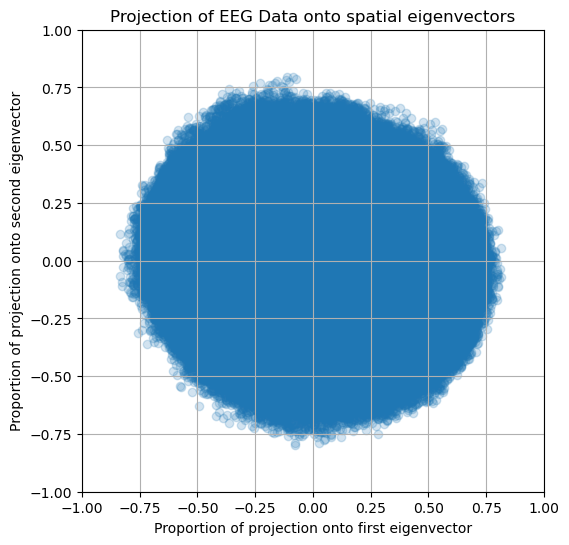

In [904]:
# data is slightly more elongated across second eigenvector
plt.figure(figsize=(10, 6))
plt.scatter(proj_U1_norm, proj_U2_norm, alpha=0.2)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('Proportion of projection onto first eigenvector')
plt.ylabel('Proportion of projection onto second eigenvector')
plt.title('Projection of EEG Data onto spatial eigenvectors')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()

We see that the proportion of projected data is pretty much randomly distributed around zero. The width is slightly bigger than the height, which implies a higher range of projections on the first eigenvector--this is expected. There is also a very slight imperfection at the top of the circle.

Also, even though it's random, the dispersion is relatively high, reaching up to 75% for a few timepoints. This, however, could just be (and most likely is) the result of very noisy trials that reach these correlations by sheer chance.

However, something interesting happens if we don't normalize.

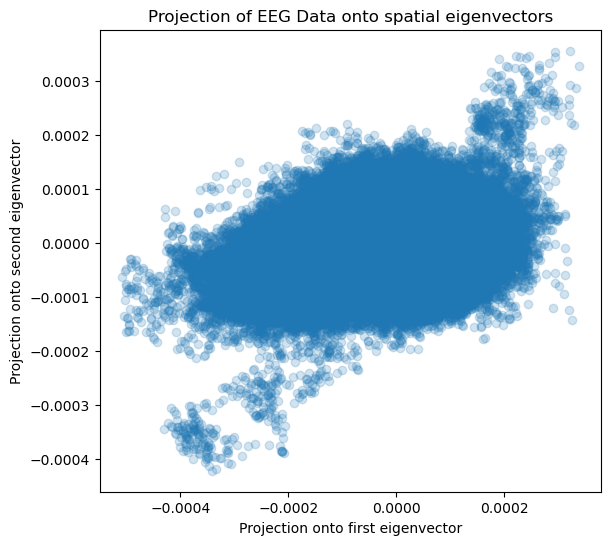

In [905]:
plt.figure(figsize=(10, 6))
plt.scatter(proj_U1, proj_U2, alpha=0.2)
plt.xlabel('Projection onto first eigenvector')
plt.ylabel('Projection onto second eigenvector')
plt.title('Projection of EEG Data onto spatial eigenvectors')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

A few outliers have very high correlation between the first and second eigenvector components. We know that when these are normalized, they don't stand out. So the reason why they are outliers is rather their high norm. However, this also tells us that datapoints with high norm are also highly correlated. In other words, strong signals are quite structured. This could mean high signal-to-noise ratio, and the reason why the norm is high might be that the SEP is high, while the noise remains low.

There is also a weird assymmetry, like a protuberance on the left side. This again is not present in the normalized version. Therefore, some timepoints with higher amplitudes have higher negative projections onto the first eigenvector. This also indicates higher signal-to-noise ratio, but it's not clear whether it's the same type of source.

Does the average data show this structure? Let's plot the projection of the average this time, on the first two eigenvectors (of the average).

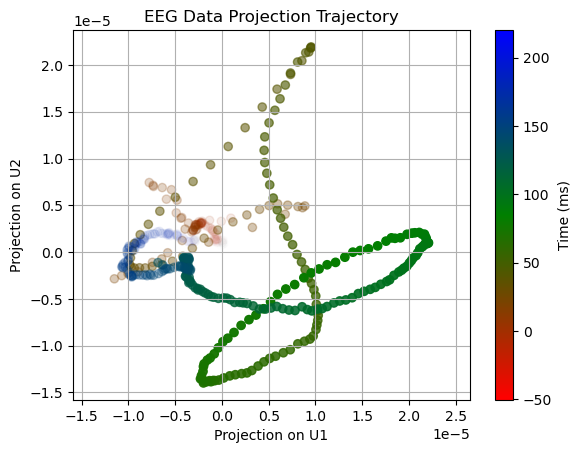

In [906]:
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['red', 'green', 'blue'])
norm = plt.Normalize(-50, 220)

proj_U1_avg = np.dot(U[:, 0], avg_data)
proj_U2_avg = np.dot(U[:, 1], avg_data)

alpha_values = np.abs(np.sin(np.linspace(0,np.pi,len(proj_U1_avg))))**4  # Gradually increase transparency

# Plot the trajectory (proj_U1 vs proj_U2)
plt.scatter(S[0]*Vh[0], S[1]*Vh[1], c=np.linspace(-50,220,len(proj_U1_avg)), cmap=cmap, norm=norm, alpha=alpha_values)

plt.colorbar(label='Time (ms)', values=np.linspace(-50,220,len(proj_U1_avg)))

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.axis('equal')
plt.grid()
plt.show()

This does look quite structured, in the sense that most of the curve looks either smooth or has isolated singularities. That is, of course, except for the beginning and end of the signal.

Next we apply SVD/PCA on each individual trial. Perhaps the principal components with the SEP are there in individual trials, but not exactly the same as in the average because of noise...

In [893]:
# get epochs, channels and timepoints and create list to store principle components for each epoch 
def explained_variance_ratio(singular_values, total_samples):
    # Calculate the total variance in the dataset
    total_variance = np.sum(singular_values**2) / (total_samples - 1)
    
    # Calculate the explained variance for each component
    explained_variances = (singular_values**2) / (total_samples - 1) / total_variance
    
    return explained_variances

epochs, channels, timepoints = data.shape
num_components = 5
components_array = np.zeros((epochs,num_components,timepoints))
sing_vals_array = np.zeros((epochs,num_components))
explained_vars = np.zeros((epochs,num_components))
U_array = np.zeros((epochs,channels,num_components))

for epoch in tqdm(range(epochs)):
    # get data for each epoch 
    epoch_data = data[epoch, :, :]

    # apply PCA 
    #pca_per_trial =  PCA()
    #X_transformed = pca_per_trial.fit_transform(epoch_data)

    U_per_trial, sing_vals, components = svds(epoch_data - np.mean(epoch_data, axis=0), num_components)

    components_array[epoch] = components[::-1]
    sing_vals_array[epoch] = sing_vals[::-1]
    # explained_var_trial = explained_variance_ratio(sing_vals, sing_vals.shape[0])
    explained_vars[epoch] = explained_variance_ratio(sing_vals[::-1], sing_vals.shape[0])
    U_array[epoch] = U_per_trial[::-1]

    # get first five principal components and singular values 
    # components = pca_per_trial.components_[:5]
    # components_list.append(components)
    #sing_vals = pca_per_trial.singular_values_
    #sing_vals_list.append(sing_vals)
    #explained_var_trial = explained_variance_ratio(sing_vals, sing_vals.shape[0])
    #explained_vars.append(explained_var_trial)
    #U_per_trial = (X_transformed / sing_vals)[:5] 
    #U_list.append(U_per_trial)


# get mean over all epochs
# components_array = np.array(components_list)
avg_explained_var = np.mean(explained_vars, axis=0)
avg_V = np.mean(components_array, axis=0)
avg_S = np.mean(sing_vals_array, axis=0)
avg_U = np.mean(U_array, axis=0)

100%|██████████| 6038/6038 [00:21<00:00, 282.37it/s]


In [842]:
'''# apply PCA to average data 
pca = PCA(n_components=2)
pca.fit(avg_data)

first_two_comp = pca.components_'''

Taking the average of these two components over trials, we see the pretty picture disappears.

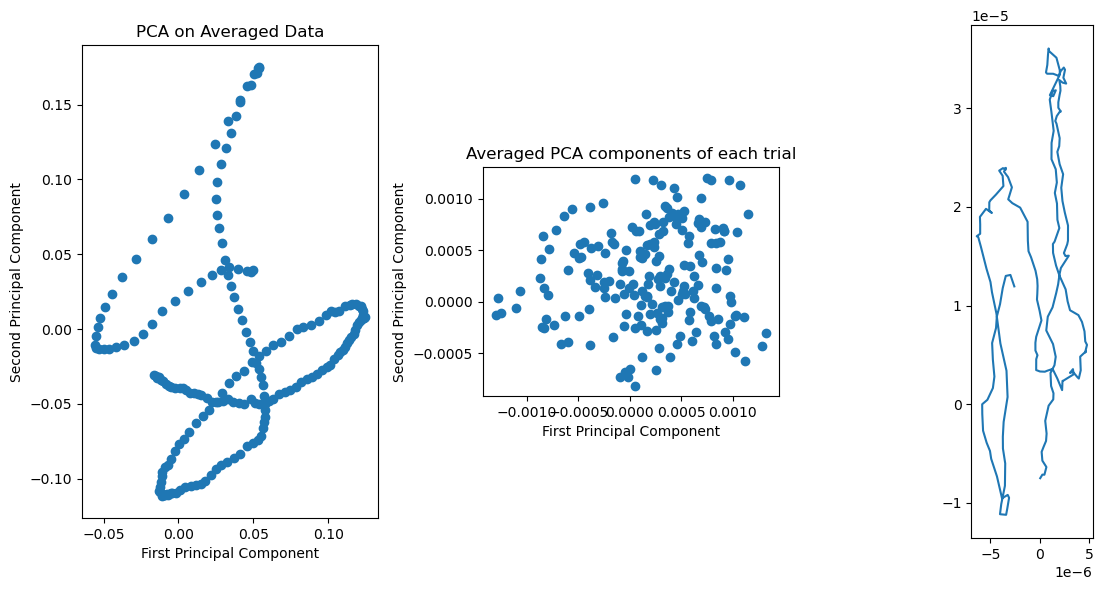

In [909]:
# create figure with two subplots 

t1 = 150
t2 = 350

fig, axes = plt.subplots(1, 3, figsize=(12,6))

# first subplot of eigenvectors of averaged data 
axes[0].scatter(Vh[0,t1:t2], Vh[1,t1:t2])
axes[0].set_title('PCA on Averaged Data')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_aspect('equal')

# second subplot of averaged eigenvectors of each trial 
axes[1].scatter(avg_V[0][t1:t2], avg_V[1][t1:t2])
axes[1].set_title('Averaged PCA components of each trial')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_aspect('equal')

# 
axes[2].plot((np.linalg.inv(np.diag(avg_S)) @ np.dot(avg_U.T, avg_data))[0][t1:t2],(np.linalg.inv(np.diag(avg_S)) @ np.dot(avg_U.T, avg_data))[1][t1:t2])
axes[2].set_aspect('equal')


plt.tight_layout()
plt.show()

In [15]:
proj_U1_avg = np.dot(avg_U[:,0], data)
proj_U2_avg = np.dot(avg_U[:,1], data)

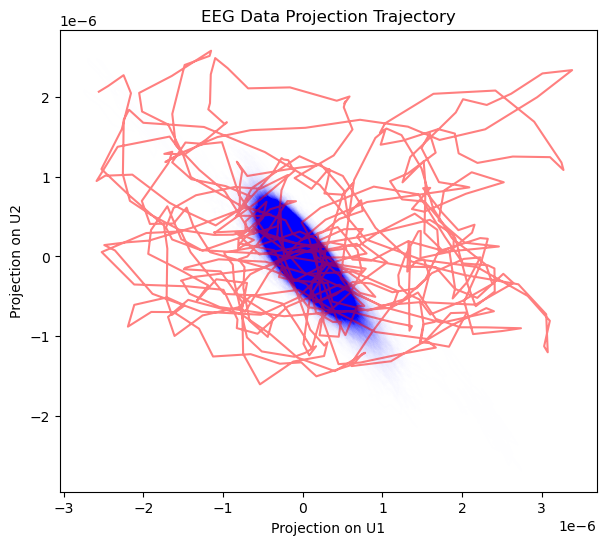

In [16]:
# Plot the trajectory (proj_U1 vs proj_U2)
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1_avg, proj_U2_avg):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue')  # Each trial

plt.plot(avg_S[0]*avg_V[0], avg_S[1]*avg_V[1], alpha=0.5, color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.gca().set_aspect('equal')
plt.show()

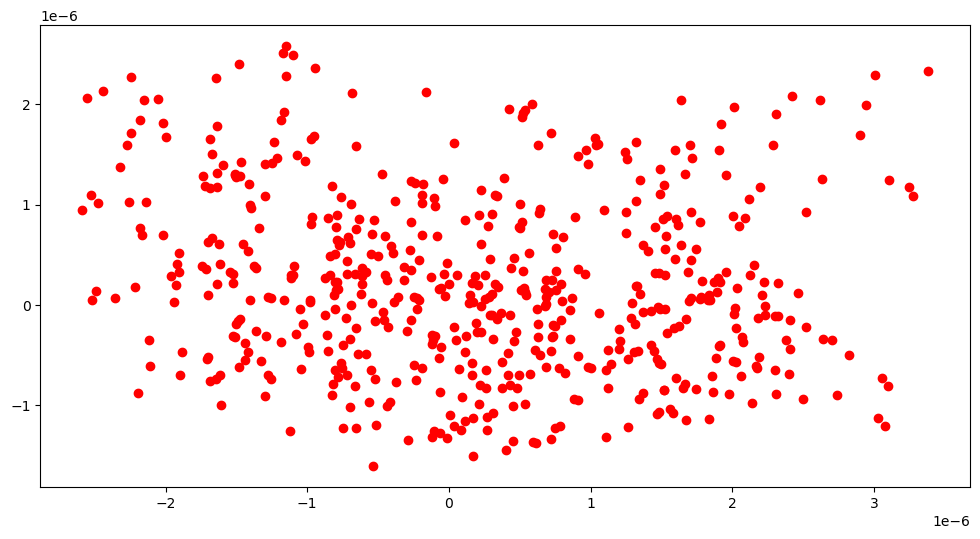

In [17]:
# plot only trajectory 
plt.figure(figsize=(12, 6))
plt.scatter(avg_V[0] * avg_S[0], avg_V[1] * avg_S[1], color='red')
plt.show()

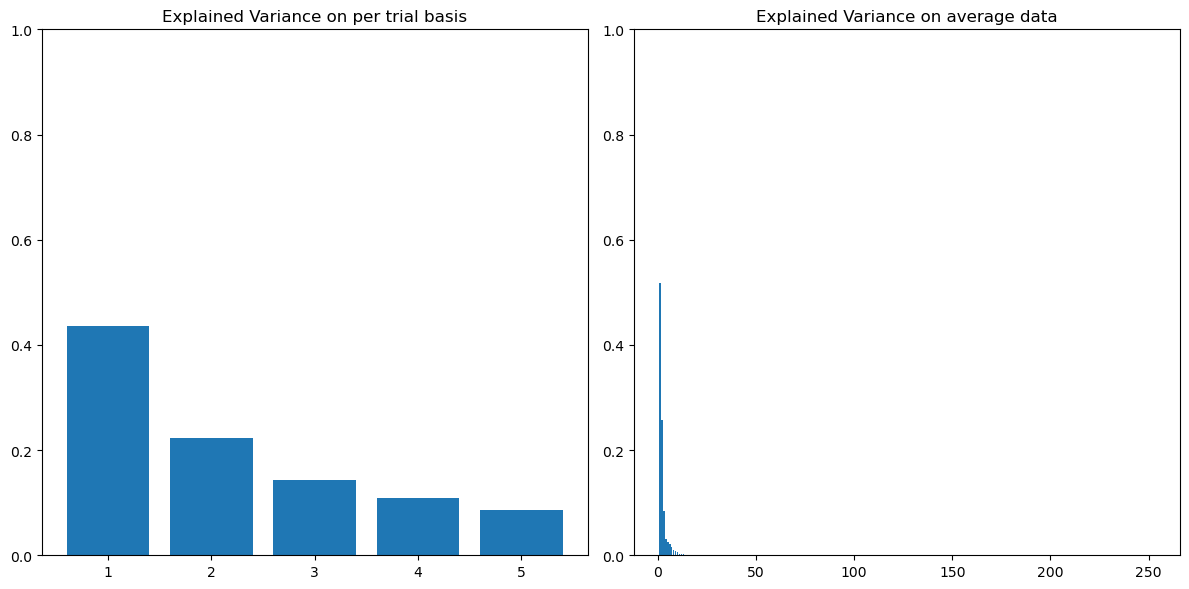

In [863]:
# get explained variance of linear PCA on a per trial basis and on average data 
def explained_variance_ratio(singular_values, total_samples):
    # Calculate the total variance in the dataset
    total_variance = np.sum(singular_values**2) / (total_samples - 1)
    
    # Calculate the explained variance for each component
    explained_variances = (singular_values**2) / (total_samples - 1) / total_variance
    
    return explained_variances

explaned_var_ratio_avg = explained_variance_ratio(S, S.shape[0])
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# plot explained variance on per trial basis 
axes[0].bar(range(1, len(avg_explained_var) + 1), avg_explained_var, align='center')
axes[0].set_ylim(0, 1)
axes[0].set_title('Explained Variance on per trial basis')

# plot explained variance of averaged data 
axes[1].bar(range(1, len(explaned_var_ratio_avg) + 1), explaned_var_ratio_avg, align='center')
axes[1].set_ylim(0, 1)
axes[1].set_title('Explained Variance on average data')

plt.tight_layout()
plt.show()

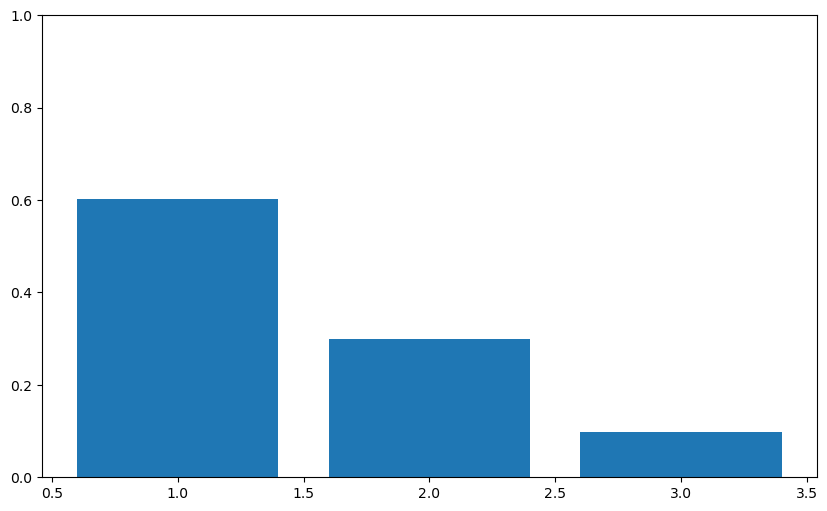

In [864]:
# get the importance of eigenvalues for KernelPCA, note that the explained variance ratio cannot be computed explitely, since the kernel matrix does not correspond to the covariance matrix 
kpca = KernelPCA(kernel='rbf', n_components=3)
kpca.fit(avg_data.T)

lambdas = kpca.eigenvalues_
explained_variance_ratio = lambdas / np.sum(lambdas)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center')
plt.ylim(0, 1)
plt.show()

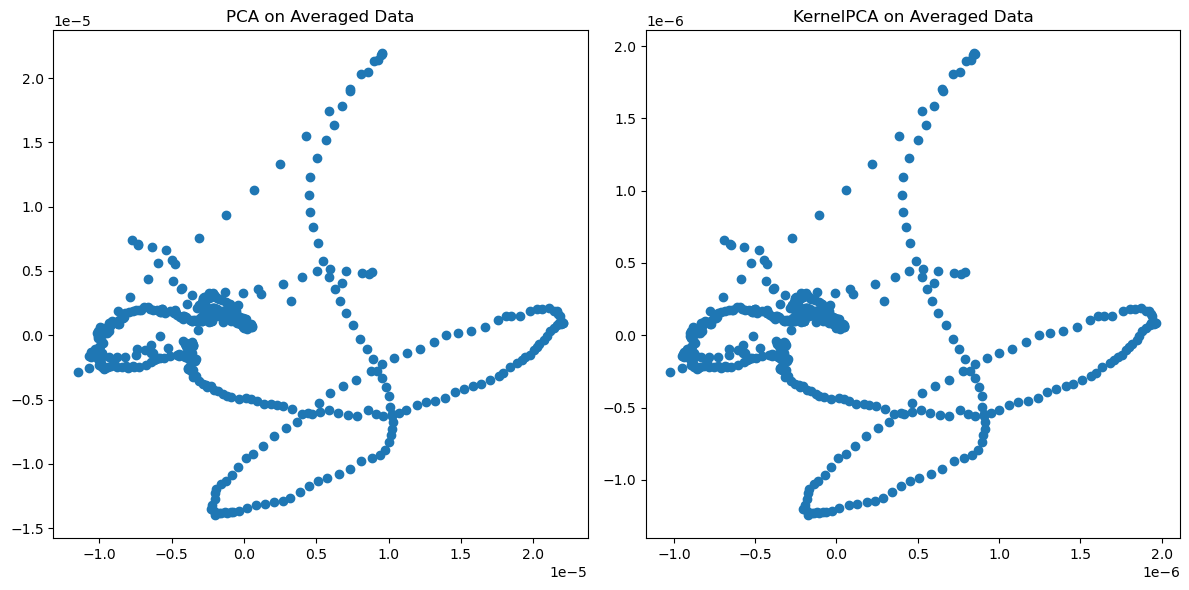

In [865]:
# This may indicate that KernelPCA works a little bit better when downprojecting the data, let's examine this 
pca_transf = pca.fit_transform(avg_data.T)
kpca_transf = kpca.fit_transform(avg_data.T)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].scatter(pca_transf[:, 0], pca_transf[:, 1])
axes[0].set_title('PCA on Averaged Data')

axes[1].scatter(kpca_transf[:, 0], kpca_transf[:, 1])
axes[1].set_title('KernelPCA on Averaged Data')

plt.tight_layout()
plt.show()

In [21]:
# As can be seen KernelPCA did not accomplish anything, which Linear PCA was not already capable of doing
epochs, channels, timepoints = data.shape
first_eig_vec_of_each_epoch = []


for epoch in tqdm(range(epochs)):
    # get data for each epoch 
    epoch_data = data[epoch, :, :]

    # apply PCA 
    pca_per_trial =  PCA(n_components=2)
    X_transformed = pca_per_trial.fit(epoch_data)

    # get first two principle components
    eig_vec = pca_per_trial.components_
    first_eig_vec_of_each_epoch.append(eig_vec)


# store all principle components in an array
first_eig_vec_of_each_epoch = np.array(first_eig_vec_of_each_epoch)

100%|██████████| 6038/6038 [00:23<00:00, 254.95it/s]


In [22]:
first_eig_vec_of_each_epoch.shape

(6038, 2, 554)

In [23]:
# compute similarity matrices, meaning each pairwise dot product of the eigenvectors of each epoch to understand the differences in dynamics of each epoch 
first_similarity_matrix = np.abs(first_eig_vec_of_each_epoch[:, 0, :] @  first_eig_vec_of_each_epoch[:, 0, :].T)
second_similarity_matrix = np.abs(first_eig_vec_of_each_epoch[:, 1, :] @  first_eig_vec_of_each_epoch[:, 1, :].T)

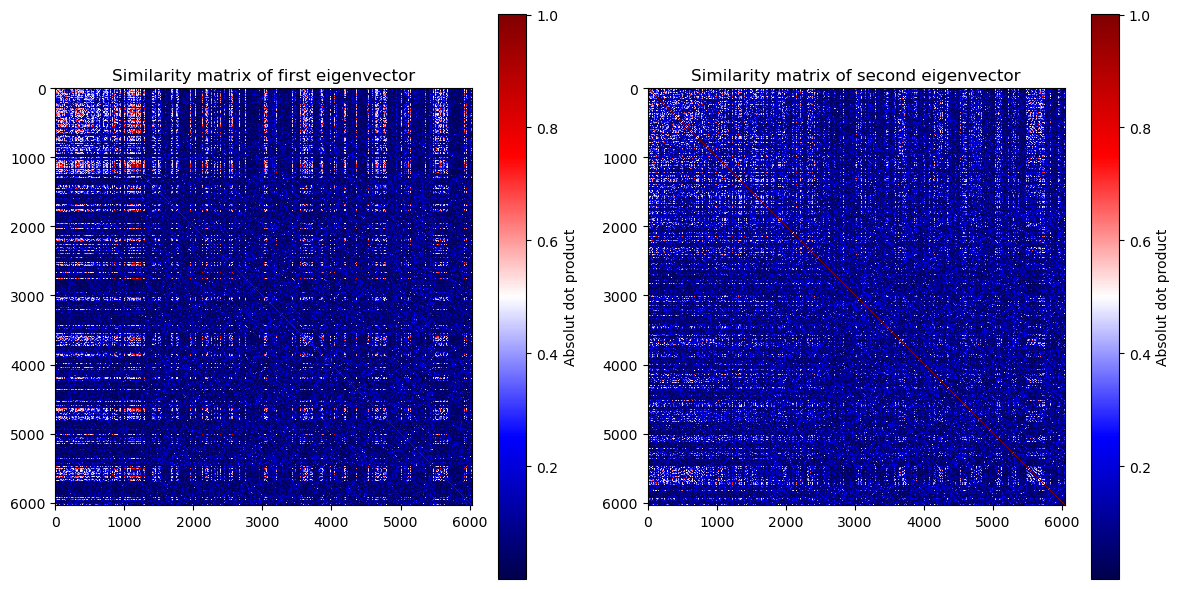

In [24]:
# plot the similarity matrices for the first two principal components 
fig, axes = plt.subplots(1, 2, figsize=(12,6))


im_1 = axes[0].imshow(first_similarity_matrix, cmap='seismic', interpolation='nearest')
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolut dot product')
axes[0].set_title('Similarity matrix of first eigenvector')

im_2 = axes[1].imshow(second_similarity_matrix, cmap='seismic', interpolation='nearest')
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolut dot product')
axes[1].set_title('Similarity matrix of second eigenvector')

plt.tight_layout()
plt.show()

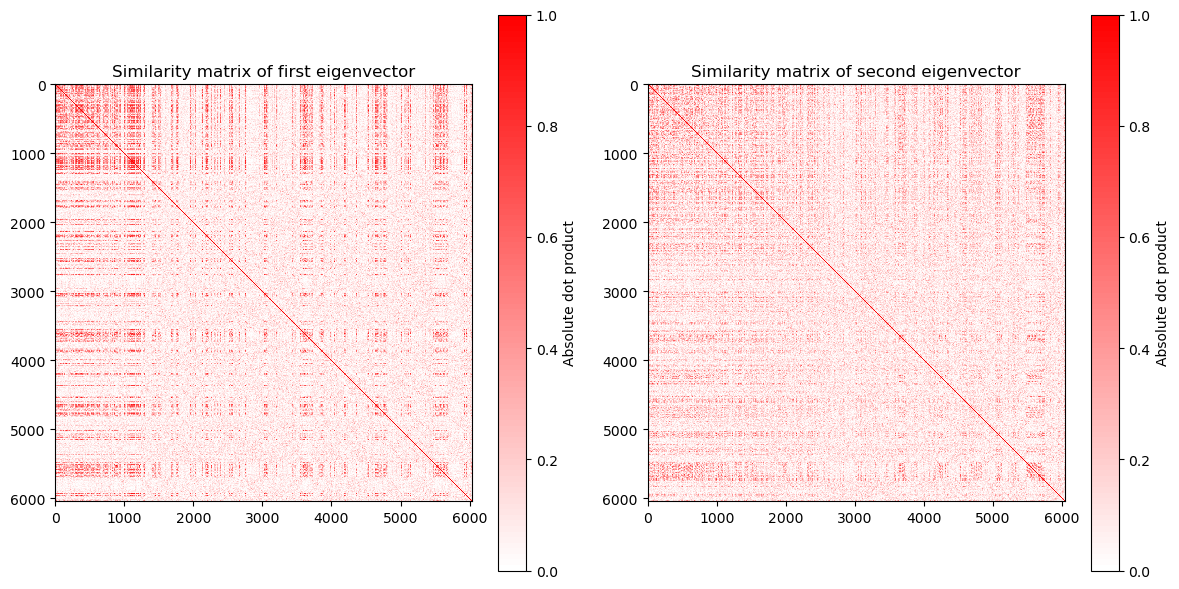

In [25]:
# Create a custom colormap to enhance visualizing the eigenvectors with high similarity 
colors = [(1, 1, 1), (1, 0, 0)]  
n_bins = 100 
cmap_name = 'white_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

im_1 = axes[0].imshow(first_similarity_matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolute dot product')
axes[0].set_title('Similarity matrix of first eigenvector')

im_2 = axes[1].imshow(second_similarity_matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolute dot product')
axes[1].set_title('Similarity matrix of second eigenvector')

plt.tight_layout()
plt.show()


In [26]:
# thresholding the similarities of the eigenvectors 
threshold = 0.5
num_epochs = 1000
count = np.sum(first_similarity_matrix > threshold, axis=1)
epochs_with_high_sim = np.where(count >= num_epochs)[0]

In [27]:
epochs_with_high_sim.shape

(249,)

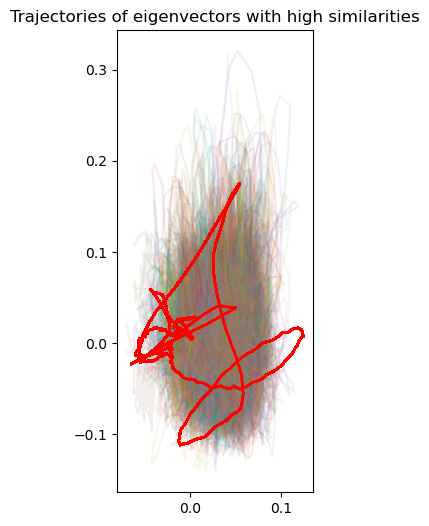

In [28]:
first_eig_vecs_high_sim = first_eig_vec_of_each_epoch[epochs_with_high_sim, 0, :]
second_eig_vecs_high_sim = first_eig_vec_of_each_epoch[epochs_with_high_sim, 1, :]

fig, ax = plt.subplots(figsize=(12,6))

# plot the first two eigenvectors with high similarities to other epochs 
for i in range(len(epochs_with_high_sim)):
    ax.plot(first_eig_vecs_high_sim[i], second_eig_vecs_high_sim[i], alpha=0.1)
    ax.plot(first_two_comp[0], first_two_comp[1], color='red')
    ax.set_aspect('equal')
ax.set_title('Trajectories of eigenvectors with high similarities')


plt.show()

In [29]:
dot_product_matrices = np.tensordot(components_array, components_array.T,1).transpose(0,3,1,2)
similarity = np.linalg.svd(dot_product_matrices, compute_uv=False)
similarity = similarity[:,:,0]

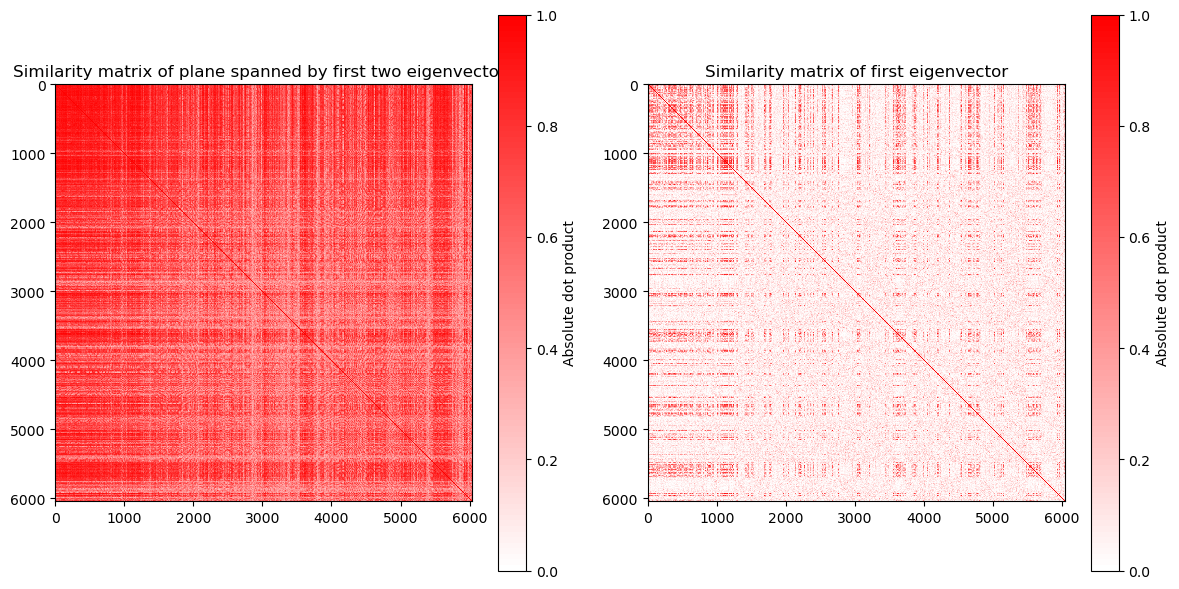

In [30]:
# Create a custom colormap to enhance visualizing the eigenvectors with high similarity 
colors = [(1, 1, 1), (1, 0, 0)]  
n_bins = 100 
cmap_name = 'white_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


fig, axes = plt.subplots(1,2,figsize=(12,6))

im_1 = axes[0].imshow(similarity, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolute dot product')
axes[0].set_title('Similarity matrix of plane spanned by first two eigenvectors')

im_2 = axes[1].imshow(np.abs(dot_product_matrices.diagonal(axis1=2,axis2=3)[:,:,0]), cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolute dot product')
axes[1].set_title('Similarity matrix of first eigenvector')

plt.tight_layout()
plt.show()

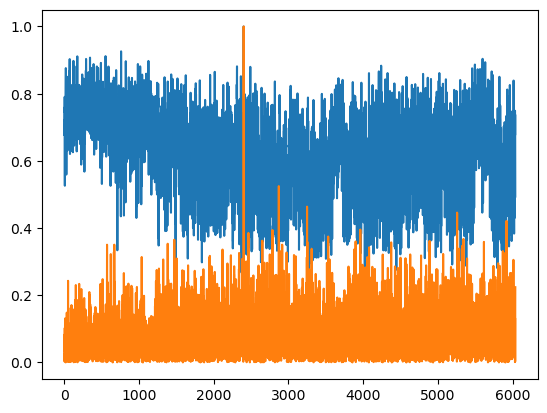

In [31]:
plt.plot(similarity[2400])
plt.plot(np.abs(dot_product_matrices.diagonal(axis1=2,axis2=3)[:,:,0])[2400])

In [465]:
# get epochs, channels and timepoints and create list to store principle components for each epoch 
def explained_variance_ratio(singular_values, total_samples):
    # Calculate the total variance in the dataset
    total_variance = np.sum(singular_values**2) / (total_samples - 1)
    
    # Calculate the explained variance for each component
    explained_variances = (singular_values**2) / (total_samples - 1) / total_variance
    
    return explained_variances

epochs, channels, timepoints = data.shape

# Override
channels = 5
base = 45

num_components = 0
components_array_ch = np.empty(channels, dtype=np.ndarray)
sing_vals_array_ch = np.empty(channels, dtype=np.ndarray)
explained_vars_ch = np.empty(channels, dtype=np.ndarray)
U_array_ch = np.empty(channels, dtype=np.ndarray)
X_transformed_array_ch = np.empty(channels, dtype=np.ndarray)
pca_array_ch = np.empty(channels, dtype=np.ndarray)

for ch in tqdm(range(channels)):
    # get data for each epoch 
    channel_data = data[:, base+ch, :]

    # apply PCA 
    pca_array_ch[ch] =  PCA(num_components if num_components else None)
    X_transformed_array_ch[ch] = pca_array_ch[ch].fit_transform(channel_data)

    #U_per_trial, sing_vals, components = svds(channel_data, num_components)

    components_array_ch[ch] = pca_array_ch[ch].components_
    sing_vals_array_ch[ch] = pca_array_ch[ch].singular_values_
    explained_vars_ch[ch] = explained_variance_ratio(sing_vals_array_ch[ch], sing_vals_array_ch[ch].shape[0])
    U_array_ch[ch] = (X_transformed_array_ch[ch] / sing_vals_array_ch[ch])

components_array_ch = np.stack(components_array_ch)
sing_vals_array_ch = np.stack(sing_vals_array_ch)
explained_vars_ch = np.stack(explained_vars_ch)
U_array_ch = np.stack(U_array_ch)
X_transformed_array_ch = np.stack(X_transformed_array_ch)
pca_array_ch = np.stack(pca_array_ch)


# get mean over all epochs
# components_array = np.array(components_list)
avg_explained_var_ch = np.mean(explained_vars_ch, axis=0)
avg_V_ch = np.mean(components_array_ch, axis=0)
avg_S_ch = np.mean(sing_vals_array_ch, axis=0)
avg_U_ch = np.mean(U_array_ch, axis=0)

100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


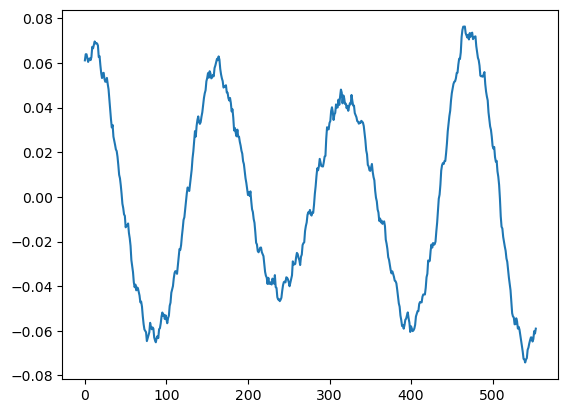

In [851]:
plt.plot(components_array_ch[1,7])

1.0


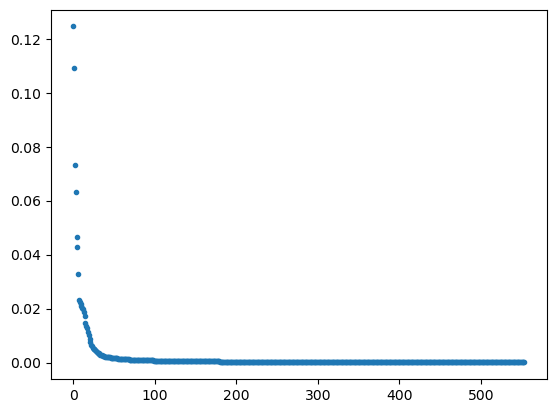

In [469]:
plt.plot(explained_vars_ch[0],'.')
print(np.sum(explained_vars_ch[0]))

Text(0.5, 1.0, 'Original data and reconstruction of 46th channel of the average with 100 components.')

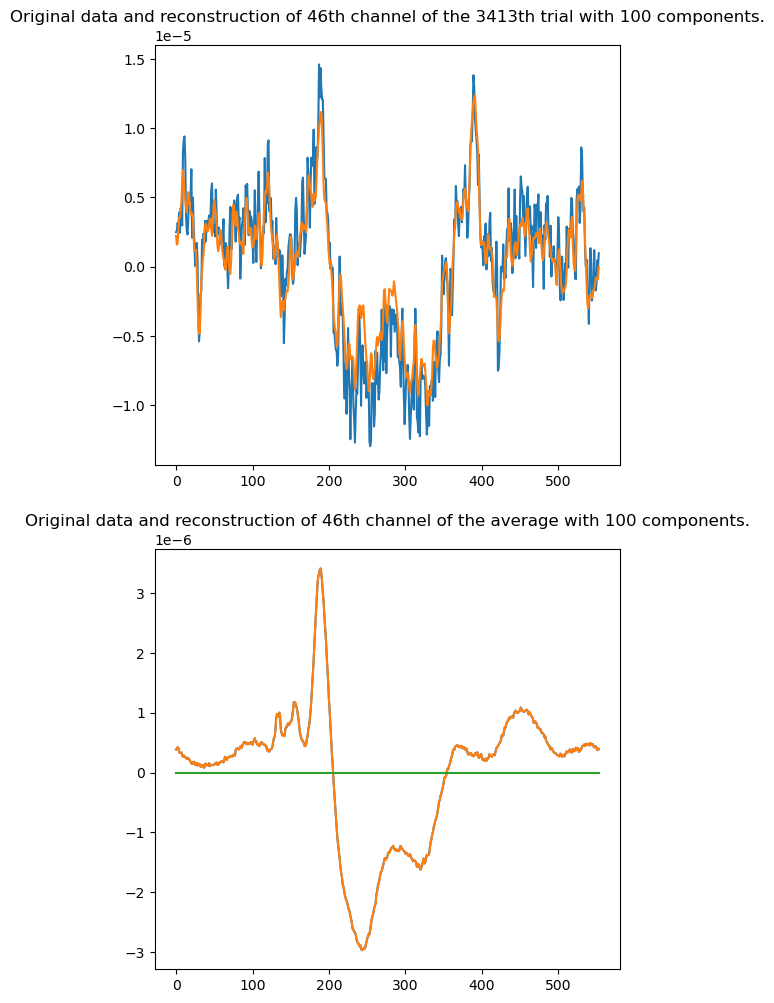

In [853]:
ch_select = 1
tr_select = 3413#np.random.randint(0,np.shape(data)[0])
comp_select = 100

reconstructed_data = np.dot(U_array_ch[ch_select][:,:comp_select] @ np.diag(sing_vals_array_ch[0][:comp_select]),components_array_ch[ch_select][:comp_select])

#plt.plot(pca_array_ch[ch_select].inverse_transform(X_transformed_array_ch[ch_select])[tr_select])

fig, axes = plt.subplots(2,1,figsize=(6,12))

axes[0].plot(data[tr_select,base+ch_select])
axes[0].plot(reconstructed_data[tr_select])
axes[0].set_title('Original data and reconstruction of ' + str(base + ch_select) + 'th channel of the ' + str(tr_select) + 'th trial with ' + str(min(sing_vals_array_ch[0].shape[0], comp_select)) + ' components.')

axes[1].plot(np.mean(data[:,base+ch_select],axis=0))
axes[1].plot(avg_data[base+ch_select])
axes[1].plot(np.mean(reconstructed_data,axis=0))
axes[1].set_title('Original data and reconstruction of ' + str(base + ch_select) + 'th channel of the average with ' + str(min(sing_vals_array_ch[0].shape[0], comp_select)) + ' components.')

The following plot shows correlation between average signal of channel ch and the trials between t and t+n_trial.

Included (orange) is a random signal with the same mean and standard deviation.

This suggests that the correlation is essentially gaussian (this is confirmed below).

1160

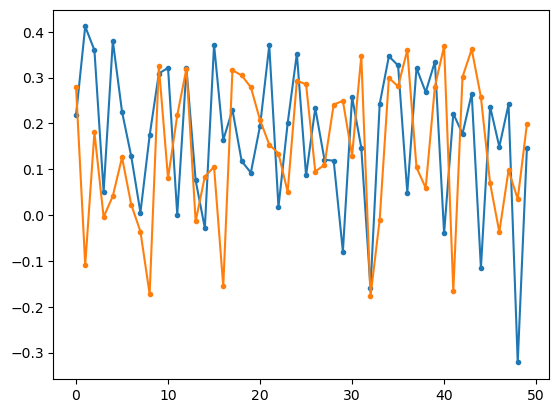

In [860]:
# Run multiple times to get different random window of n_trials trials.

ch=76
n_trials = 50
t = np.random.randint(0,data.shape[0] - n_trials)
trials_projection_all = np.dot(avg_data[ch], data[:,ch].T)/(np.linalg.norm(avg_data[ch])*np.linalg.norm(data[:,ch],axis=1))
trials_projection_window = trials_projection_all[t:t+n_trials]

random_normal_signal = np.random.normal(loc=np.mean(trials_projection_window), scale=np.std(trials_projection_window), size=trials_projection_window.shape)

plt.plot(trials_projection_window,marker='.')
plt.plot(random_normal_signal,marker='.')
np.mean(np.dot(avg_data[ch], data[:,ch].T)/(np.linalg.norm(avg_data[ch])*np.linalg.norm(data[:,ch],axis=1)))
np.argmax(np.dot(avg_data[ch], data[:,ch].T)/(np.linalg.norm(avg_data[ch])*np.linalg.norm(data[:,ch],axis=1)))

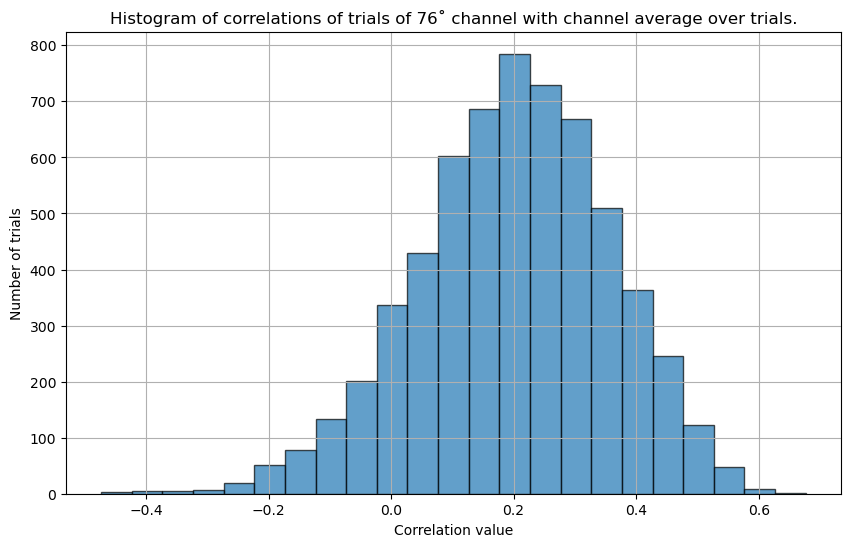

In [629]:
# Step 1: Define the number of bins based on the bin size
bin_size = 0.05  # Define your bin size
bins = np.arange(trials_projection_all.min(), trials_projection_all.max() + bin_size, bin_size)

# Step 2: Calculate the histogram
hist, bin_edges = np.histogram(trials_projection_all, bins=bins)

# Step 3: Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(trials_projection_all, bins=bins, edgecolor='black', alpha=0.7)
plt.title('Histogram of correlations of trials of ' + str(ch) + '˚ channel with channel average over trials.')
plt.xlabel('Correlation value')
plt.ylabel('Number of trials')
plt.grid(True)
plt.show()

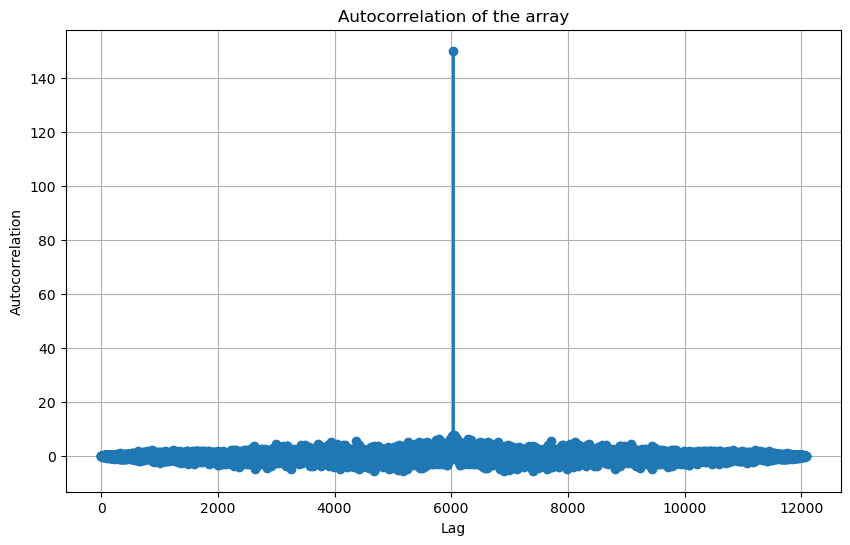

In [655]:
from scipy.signal import correlate

# Compute the autocorrelation
autocorrelation = correlate(trials_projection_all - np.mean(trials_projection_all), trials_projection_all - np.mean(trials_projection_all))

# We want the second half of this result, which represents non-negative lags
#autocorrelation = autocorrelation[autocorrelation.size // 2:]

# Plot the autocorrelation
plt.figure(figsize=(10, 6))
plt.plot(autocorrelation, marker='o')
plt.title('Autocorrelation of correlation with the average')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

This autocorrelation plot suggests that _correlation with the average is random over the trials_. The fact that one trial is more or less correlated to the average (to the SEP) doesn't say anything about how correlated the next trial will be. That's why
it makes sense to plot the histogram above: it's the same to scramble the trials, what matters is the count. This confirms what visual inspection suggested above: correlation with the average is a r.v. with mean and std that depend on the channel (see topoplot below). The distribution doesn't seem to be gaussian, though, because it is slightly skewed to the left.

A hypothesis I have for the skewness is that the distribution is a combination of two gaussians, a flatter one centered at zero, and the one centered at the mode. This would be because a trial is first sampled with some (high) probability from the SEP gaussian, but there's also some chance that there is no SEP whatsoever at that given trial.

In [487]:
ch = np.random.randint(0,np.shape(avg_data)[0]-1)

print("Channel: " + str(ch))
print("Average correlation between channel signal and average (over trials):", np.mean(np.dot(avg_data[ch], data[:,ch].T)/(np.linalg.norm(avg_data[ch])*np.linalg.norm(data[:,ch],axis=1))))
random_signals = np.random.normal(np.tile(np.mean(data[:,ch],axis=1),(np.shape(data[:,0])[1],1)),np.tile(np.std(data[:,ch],axis=1),(np.shape(data[:,0])[1],1)),np.shape(data[:,0])[::-1])
print("Average correlation between random signal and average (over random trials of same mean and std)", np.mean(np.dot(avg_data[ch], random_signals)/(np.linalg.norm(avg_data[ch])*np.linalg.norm(random_signals,axis=0))))

Channel: 73
Average correlation between channel signal and average (over trials): 0.05401616520645485
Average correlation between random signal and average (over random trials of same mean and std) 0.0005265107068563842


100%|██████████| 253/253 [00:52<00:00,  4.85it/s]


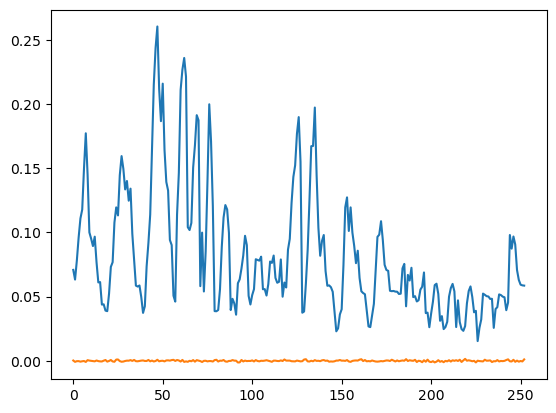

In [437]:
true_signal_corr_with_avg = np.empty(avg_data.shape[0])
random_signal_corr_with_avg = np.empty(avg_data.shape[0])
shuffle_signal_corr_with_avg = np.empty(avg_data.shape[0])

for ch in tqdm(range(avg_data.shape[0])):
    true_signal_corr_with_avg[ch] = np.mean(np.dot(avg_data[ch], data[:,ch].T)/(np.linalg.norm(avg_data[ch])*np.linalg.norm(data[:,ch],axis=1)))
    random_trials = np.random.normal(np.tile(np.mean(data[:,ch],axis=1),(np.shape(data[:,0])[1],1)),np.tile(np.std(data[:,ch],axis=1),(np.shape(data[:,0])[1],1)),np.shape(data[:,0])[::-1])
    random_signal_corr_with_avg[ch] = np.mean(np.dot(avg_data[ch], random_trials)/(np.linalg.norm(avg_data[ch])*np.linalg.norm(random_trials,axis=0)))

In [440]:
montage = mne.channels.read_custom_montage('waveguard256_duke_ug110527_adapted.elc')
raw.set_montage(montage)

/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_2073/2785304072.py:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,256 points
Good channels,253 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


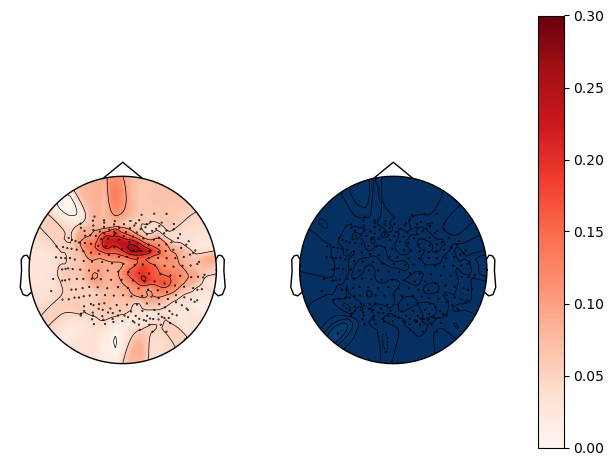

In [457]:
fig,(ax1,ax2) = plt.subplots(ncols=2)


im1, cm = mne.viz.plot_topomap(true_signal_corr_with_avg,raw.info, axes=ax1, show=False, size=3, vlim=(0,0.3))
im2, cm = mne.viz.plot_topomap(random_signal_corr_with_avg,raw.info, axes=ax2, show=False, size=3, vlim=(0,0.3))

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im1, cax=cbar_ax)

In [461]:
def array_to_thresholded_dict(arr, threshold):
    result_dict = {}
    # Using numpy's ndenumerate to get indices and values
    for index, value in np.ndenumerate(arr):
        if value >= threshold:
            result_dict[index] = value
    return result_dict

# Example usage
threshold = 0.15
thresholded_dict = array_to_thresholded_dict(true_signal_corr_with_avg, threshold)

In [463]:
thresholded_dict

{(7,): 0.17720894932099554,
 (27,): 0.15944983258704692,
 (44,): 0.16346197765136627,
 (45,): 0.21509905555829373,
 (46,): 0.24361748584061757,
 (47,): 0.2603951066337537,
 (48,): 0.21180252247538564,
 (49,): 0.18665962913006023,
 (50,): 0.21586998940393884,
 (51,): 0.1641235365117534,
 (60,): 0.21101445128762503,
 (61,): 0.22683800824969777,
 (62,): 0.23587110044047388,
 (63,): 0.221361747684233,
 (67,): 0.15053000932629867,
 (68,): 0.1678834629600106,
 (69,): 0.19133304302425178,
 (70,): 0.18733745826998577,
 (76,): 0.19979857157733494,
 (77,): 0.17090360480946026,
 (124,): 0.15225907200540834,
 (125,): 0.17675613244319602,
 (126,): 0.18982040703369446,
 (127,): 0.1550415020054016,
 (133,): 0.16718106246995426,
 (134,): 0.16733156785243067,
 (135,): 0.19727026473794368}